**Table of contents**<a id='toc0_'></a>    
- [Impl√©mentez un mod√®le de scoring](#toc1_)    
  - [Pr√©paration des donn√©es et feature engineering](#toc1_1_)    
  - [Analyse exploratoire](#toc1_2_)    
    - [Structure des donn√©es](#toc1_2_1_)    
    - [Doublons](#toc1_2_2_)    
    - [Donn√©es manquantes](#toc1_2_3_)    
    - [Distribution de la variable cible](#toc1_2_4_)    
    - [Corr√©lations](#toc1_2_5_)    
  - [Modelisation](#toc1_3_)    
    - [Mod√®les Baseline](#toc1_3_1_)    
    - [LightGBM](#toc1_3_2_)    
      - [Mod√®le LightGBM par d√©faut](#toc1_3_2_1_)    
      - [Optimisation des hyperparam√®tres](#toc1_3_2_2_)    
      - [Optimisation du seuil](#toc1_3_2_3_)    
      - [Importance globale et locale des features](#toc1_3_2_4_)    
        - [Importance globale](#toc1_3_2_4_1_)    
        - [Importance locale](#toc1_3_2_4_2_)    
    - [Sauvegarde du mod√®le](#toc1_3_3_)    
    - [Test et Sauvegarde pour tester l'API](#toc1_3_4_)    
  - [Data Drift](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Impl√©mentez un mod√®le de scoring](#toc0_)

In [ ]:
#%pip install pandas lightgbm scikit-learn matplotlib seaborn mlflow missingno imblearn shap evidently

In [ ]:
# Imports de librairies

# Librairies de base et gestion des donn√©es
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import warnings

# Mod√©lisation et √©valuation
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_validate

# Pr√©traitement et Pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Outils d'optimisation et d'explicabilit√©
import shap

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Outils MLOps et Persistance
import joblib
import mlflow
import mlflow.sklearn

In [3]:
# Configuration
warnings.simplefilter(action='ignore', category=FutureWarning)
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

## <a id='toc1_1_'></a>[Pr√©paration des donn√©es et feature engineering](#toc0_)

Notre mod√®le de scoring se base sur le kernel Kaggle "LightGBM with simple features", pour son approche de feature engineering.
Cependant, nous avons am√©lior√© cette approche en int√©grant toutes les √©tapes de traitement des donn√©es et de mod√©lisation dans une pipeline compl√®te.
Cette int√©gration a plusieurs avantages :
- Pr√©vention du Data Leakage : En encapsulant les transformations, nous nous assurons que notre mod√®le n'est pas fauss√© par des informations provenant des donn√©es de test.
- D√©ploiement simplifi√© : La pipeline unifi√©e permet de d√©ployer l'int√©gralit√© du mod√®le en une seule fois pour une API, √©vitant ainsi les erreurs de reproduction manuelle des √©tapes de pr√©traitement.
- Coh√©rence et reproductibilit√© : La pipeline garantit que chaque nouvelle donn√©e est trait√©e de la m√™me mani√®re, assurant la fiabilit√© des pr√©dictions.

In [4]:
# Fonctions utilitaires
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f}s')

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Utilisation de la m√©moire du DataFrame au d√©part: {start_mem:.2f} Mo')
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Utilisation de la m√©moire du DataFrame √† la fin: {end_mem:.2f} Mo')
    print(f'R√©duction de {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

# Fonction pour le pr√©traitement et le feature engineering
from utils import preprocess_data


In [5]:
# Chargement et Pr√©paration des Donn√©es
#--------------------------------------------------
with timer("Process application data"):
    df = pd.read_csv('application_train.csv')
    test_df = pd.read_csv('application_test.csv')
    
    df_combined = pd.concat([df, test_df], ignore_index=True)
    df_combined = df_combined[df_combined['CODE_GENDER'] != 'XNA'].reset_index(drop=True)
    df_combined = reduce_mem_usage(df_combined)

    
    train_df = df_combined[df_combined['TARGET'].notna()].copy().reset_index(drop=True)
    test_df = df_combined[df_combined['TARGET'].isna()].copy().reset_index(drop=True)
    
    train_df.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in train_df.columns]
    test_df.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in test_df.columns]
    
    train_df['TARGET'] = train_df['TARGET'].astype(int)

print("\nShape of training data:", train_df.shape)
print("Shape of testing data:", test_df.shape)
gc.collect()

Utilisation de la m√©moire du DataFrame au d√©part: 331.59 Mo
Utilisation de la m√©moire du DataFrame √† la fin: 111.44 Mo
R√©duction de 66.4%
[Process application data] done in 8s

Shape of training data: (307507, 122)
Shape of testing data: (48744, 122)


0

In [6]:
# Initialisation de MLflow
mlflow.set_experiment("Credit Scoring Model")
model_results = {}

In [7]:
# Afficher toutes les colonnes sans limite
pd.set_option('display.max_columns', None)

In [8]:
# Aper√ßu des donn√©es
train_df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

## <a id='toc1_2_'></a>[Analyse exploratoire](#toc0_)

### <a id='toc1_2_1_'></a>[Structure des donn√©es](#toc0_)

In [9]:
# Structure des donn√©es
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(16), float32(65), int16(2), int32(2), int64(1), int8(36)
memory usage: 97.4 MB


Le jeu de donn√©es d'entra√Ænement contient 307 507 lignes. Il est compos√© de 122 colonnes, incluant la variable cible (TARGET), l'identifiant des clients (SK_ID_CURR) et 120 variables explicatives.

### <a id='toc1_2_2_'></a>[Doublons](#toc0_)

In [10]:
# doublons
print("Nombre de doublons dans le jeu d'entrainement: {}".format(train_df.duplicated().sum()))
print("Nombre de doublons dans le jeu de test: {}".format(test_df.duplicated().sum()))

Nombre de doublons dans le jeu d'entrainement: 0
Nombre de doublons dans le jeu de test: 0


In [11]:
# doublons
print("Nombre IDs dupliqu√©s dans le jeu d'entrainement dans le jeu d'entrainement: {}".format(train_df['SK_ID_CURR'].duplicated().sum()))
print("Nombre IDs dupliqu√©s dans le jeu d'entrainements dans le jeu de test: {}".format(test_df['SK_ID_CURR'].duplicated().sum()))

Nombre IDs dupliqu√©s dans le jeu d'entrainement dans le jeu d'entrainement: 0
Nombre IDs dupliqu√©s dans le jeu d'entrainements dans le jeu de test: 0


### <a id='toc1_2_3_'></a>[Donn√©es manquantes](#toc0_)

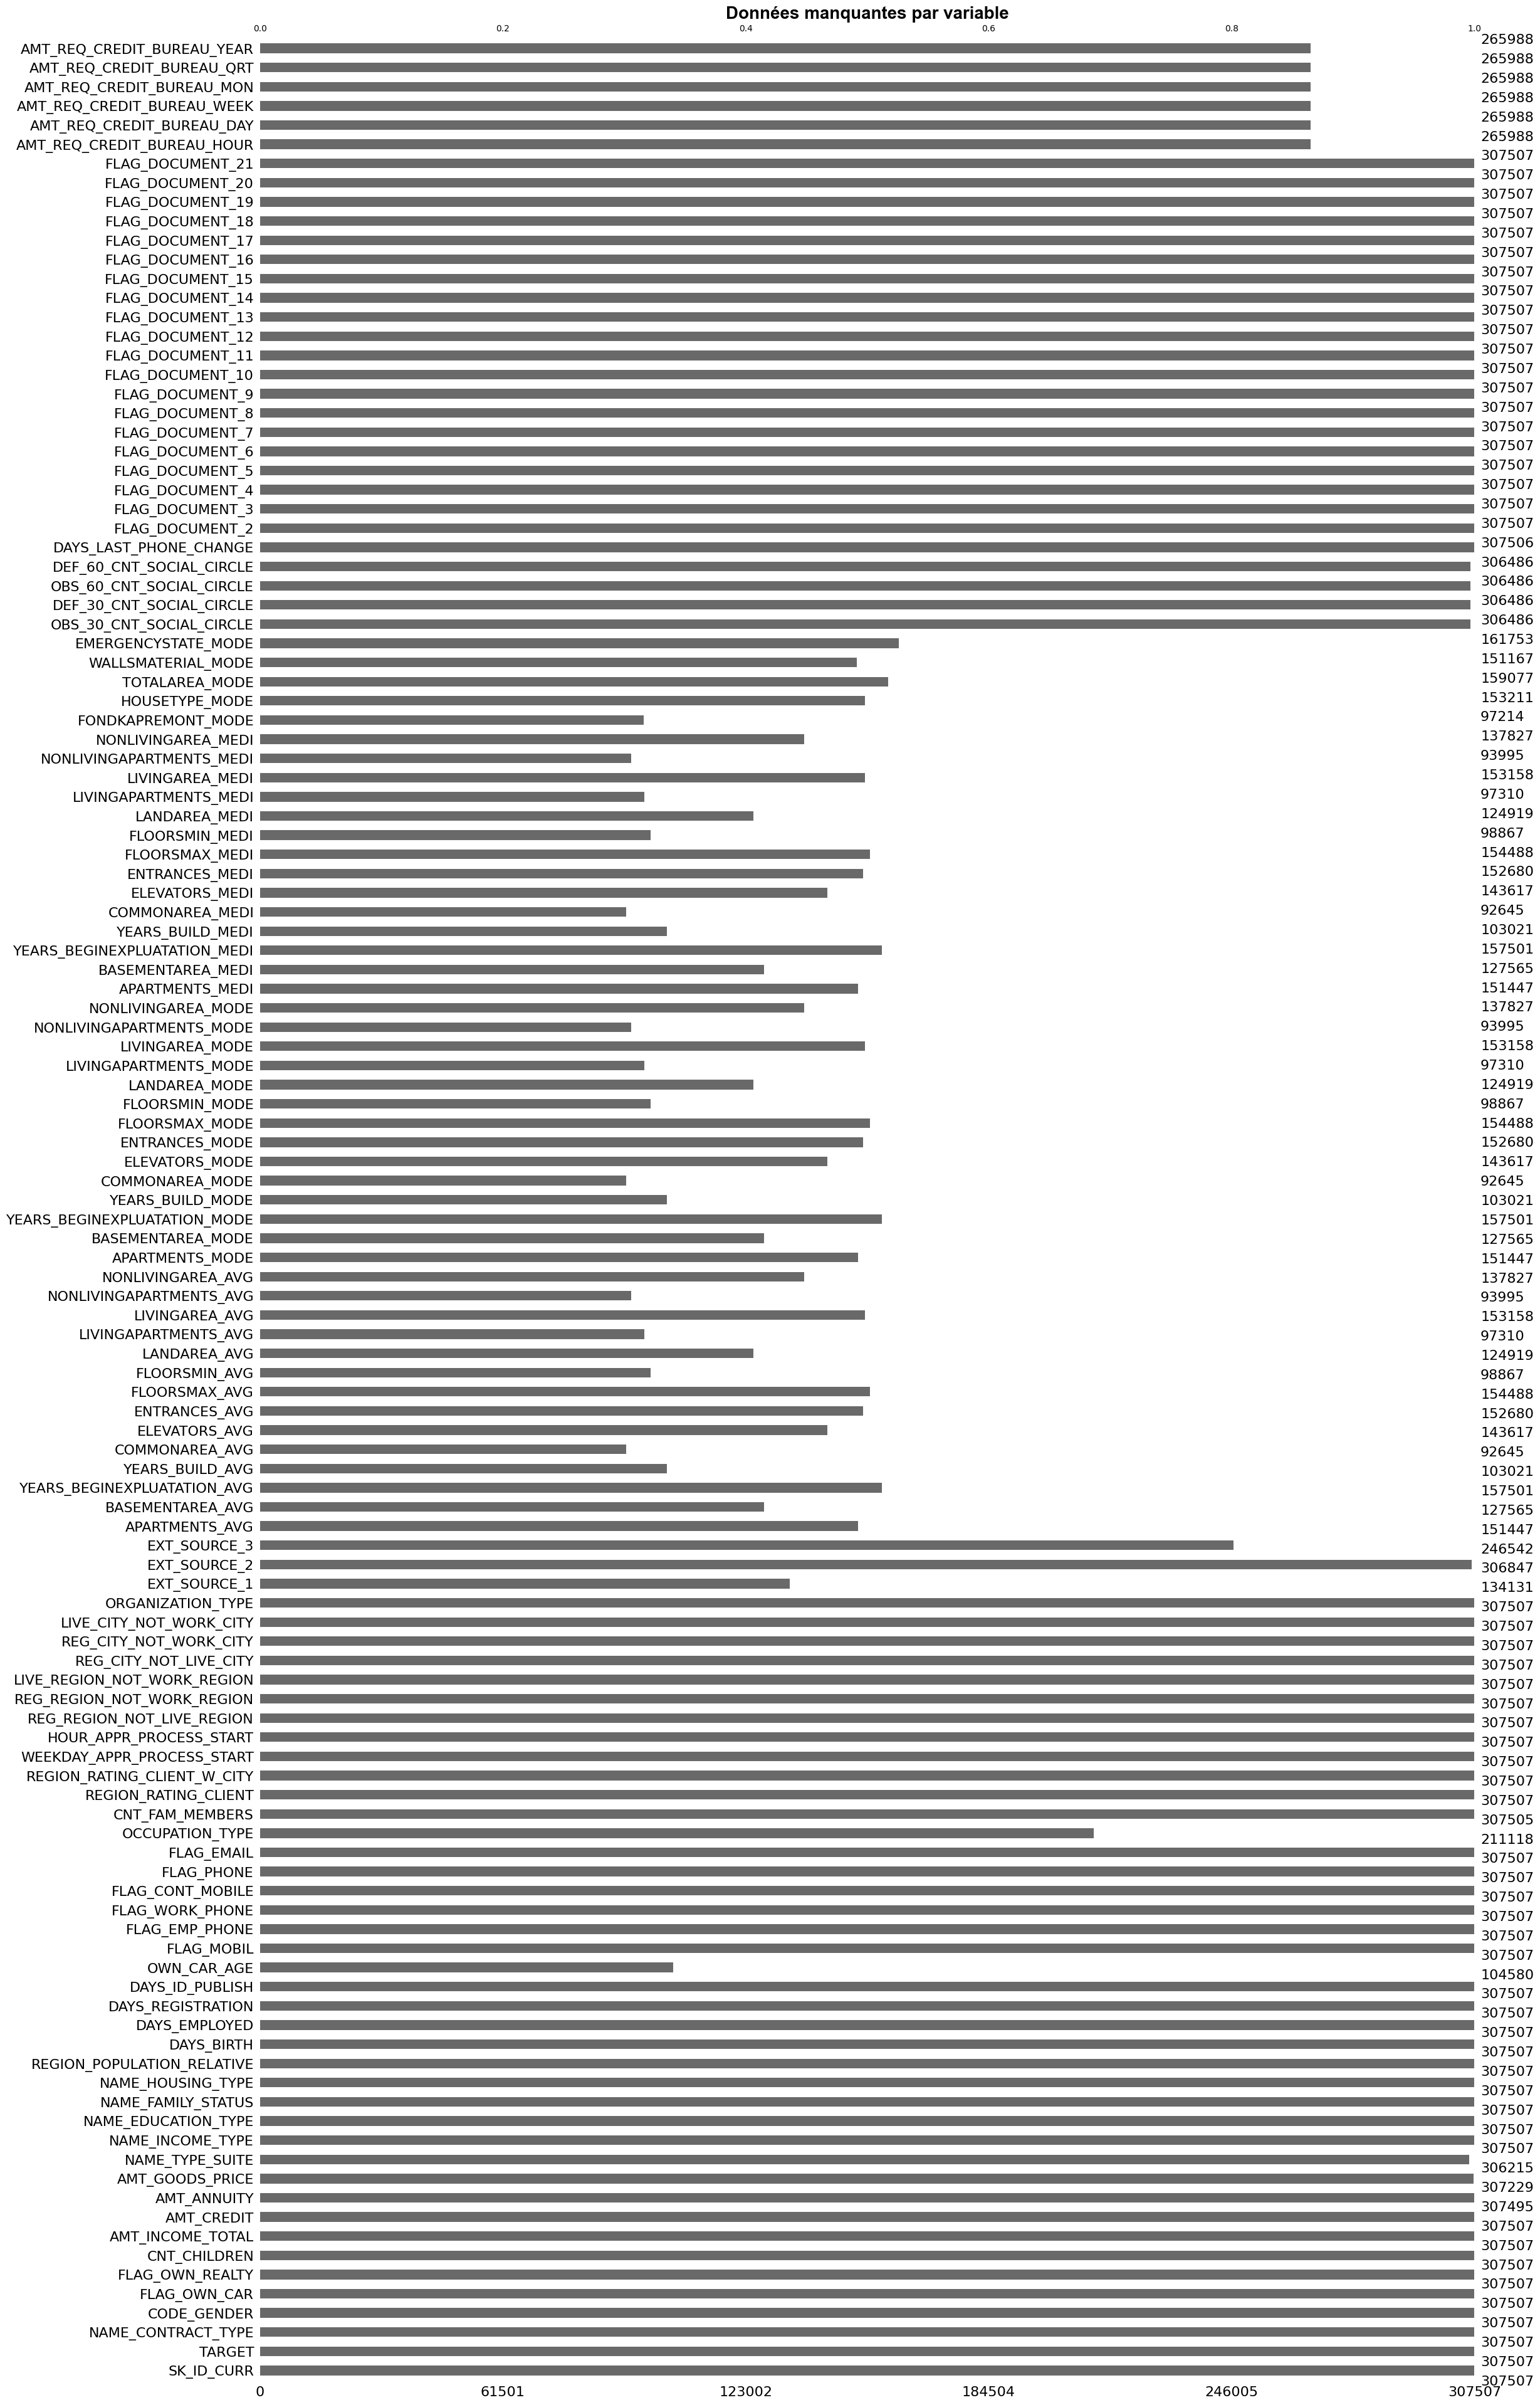

In [12]:
# Donn√©es manquantes dans le jeu de donn√©es d'entrainement 
plt.figure(figsize=(10, 6))
%matplotlib inline
msno.bar(train_df)
plt.title("Donn√©es manquantes par variable",fontname='Arial', fontsize=20, color='black', fontweight='bold')
plt.show()

In [13]:
# Variables avec des valeurs manquantes
print("Nombre de variables des donn√©es train avec des valeurs manquantes: {}".format((train_df.isna().mean()>0).sum()))
print("Nombre de variables des donn√©es test avec des valeurs manquantes: {}".format((test_df.isna().mean()>0).sum()))

Nombre de variables des donn√©es train avec des valeurs manquantes: 67
Nombre de variables des donn√©es test avec des valeurs manquantes: 65


67 variables sur 122 pr√©sentent des valeurs manquantes

In [14]:
# Variables avec 50% de leur valeurs qui sont manquantes
print("Nombre de variables des donn√©es train avec plus de 50 % de valeurs manquantes: {}".format((train_df.isna().mean()>0.5).sum()))
print("Nombre de variables des donn√©es test avec plus de 50 % de valeurs manquantes: {}".format((test_df.isna().mean()>0.5).sum()))

Nombre de variables des donn√©es train avec plus de 50 % de valeurs manquantes: 41
Nombre de variables des donn√©es test avec plus de 50 % de valeurs manquantes: 30


La n√©cessit√© de traiter les valeurs manquantes d√©pend de l'algorithme de machine learning que nous utiliserons. Les mod√®les bas√©s sur les arbres, tels que LightGBM ou XGBoost, sont capables de g√©rer les donn√©es manquantes de mani√®re native, ce qui rend l'imputation facultative.

### <a id='toc1_2_4_'></a>[Distribution de la variable cible](#toc0_)

In [15]:
counts=train_df["TARGET"].value_counts()
print(counts)

TARGET
0    282682
1     24825
Name: count, dtype: int64


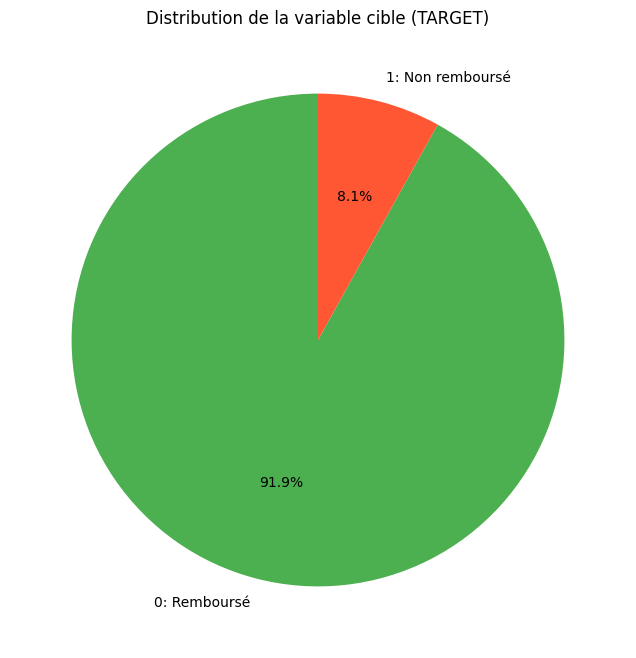

In [16]:
# Cr√©er le diagramme circulaire
plt.figure(figsize=(8, 8)) 
plt.pie(counts, labels=['0: Rembours√©', '1: Non rembours√©'], autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FF5733'])
plt.title('Distribution de la variable cible (TARGET)')
plt.show()

Le graphique illustre clairement que la classe 0 (rembours√©) repr√©sente la tr√®s grande majorit√© des donn√©es, avec 91,9 % des observations. √Ä l'inverse, la classe 1 (non rembours√©) est une classe minoritaire, ne repr√©sentant que 8,1 % du jeu de donn√©es.
On constate donc un d√©s√©quilibre des classes qui pr√©sente un d√©fi pour le machine learning car un mod√®le pourrait simplement pr√©dire la classe majoritaire (0) pour chaque observation et obtenir un score de pr√©cision tr√®s √©lev√©, tout en √©tant incapable de bien identifier les cas minoritaires qui sont souvent les plus importants √† d√©tecter.  
Pour traiter ce d√©s√©quilibre, il est crucial d'utiliser des techniques adapt√©es avant d'entra√Æner le mod√®le, comme :
- Techniques de sur√©chantillonnage (oversampling) : Dupliquer les observations de la classe minoritaire. Une m√©thode populaire est SMOTE (Synthetic Minority Over-sampling Technique), qui g√©n√®re de nouvelles donn√©es pour la classe minoritaire.  
- Techniques de sous-√©chantillonnage (undersampling) : R√©duire le nombre d'observations de la classe majoritaire.  
- Utilisation des hyperparam√®tres des mod√®les : De nombreux algorithmes, notamment les mod√®les d'arbres comme LightGBM et XGBoost, ou la R√©gression Logistique, int√®grent des hyperparam√®tres qui permettent de g√©rer le poids des classes durant l'entra√Ænement. L'avantage principal est que cette m√©thode agit directement sur la fonction de co√ªt du mod√®le, ce qui le pousse √† accorder plus d'importance aux erreurs de pr√©diction sur la classe minoritaire, sans modifier le jeu de donn√©es lui-m√™me. C'est une approche plus native et souvent plus performante et c'est celle que nous choisissons pour traiter le desequilibre des classes de notre mod√®le

### <a id='toc1_2_5_'></a>[Corr√©lations](#toc0_)

In [17]:
# corr√©lations avec la target 
# S√©lection des colonnes num√©riques pour le calcul de la corr√©lation
numerical_df = train_df.select_dtypes(include=np.number)

# Calcul des corr√©lations avec la cible ('TARGET')
correlations = numerical_df.corr()['TARGET'].dropna().sort_values()

# Affichage des corr√©lations les plus positives et les plus n√©gatives
print('Corr√©lations les plus n√©gatives:\n', correlations.head(10))
print('\nCorr√©lations les plus positives:\n', correlations.tail(10))

Corr√©lations les plus n√©gatives:
 EXT_SOURCE_3                 -0.178926
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044934
FLOORSMAX_AVG                -0.044009
FLOORSMAX_MEDI               -0.043773
FLOORSMAX_MODE               -0.043231
AMT_GOODS_PRICE              -0.039647
REGION_POPULATION_RELATIVE   -0.037225
ELEVATORS_AVG                -0.034202
Name: TARGET, dtype: float64

Corr√©lations les plus positives:
 FLAG_DOCUMENT_3                0.044341
REG_CITY_NOT_LIVE_CITY         0.044394
FLAG_EMP_PHONE                 0.045984
REG_CITY_NOT_WORK_CITY         0.050992
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055219
REGION_RATING_CLIENT           0.058901
REGION_RATING_CLIENT_W_CITY    0.060895
DAYS_BIRTH                     0.078242
TARGET                         1.000000
Name: TARGET, dtype: float64


On a affich√© les corr√©lation les plus forte avec la target ( positivement et n√©gativement), ces corr√©lations lin√©aires semblent assez faibles.    

la target est corr√©l√©e positivement avec l'√¢ge des clients qui ici est exprim√©e en jours et enregistr√©e comme un nombre n√©gatif par rapport √† la date de la demande de pr√™t,  C'est pourquoi une corr√©lation positive avec cette variable signifie en r√©alit√© que les clients plus √¢g√©s (c'est-√†-dire avec un nombre n√©gatif plus faible, proche de z√©ro) sont associ√©s √† un risque plus faible de d√©faut de paiement.  

EXT_SOURCE_2 / 3 : Ce sont des scores provenant de sources externes. Un score plus √©lev√© indique une meilleure fiabilit√© du client

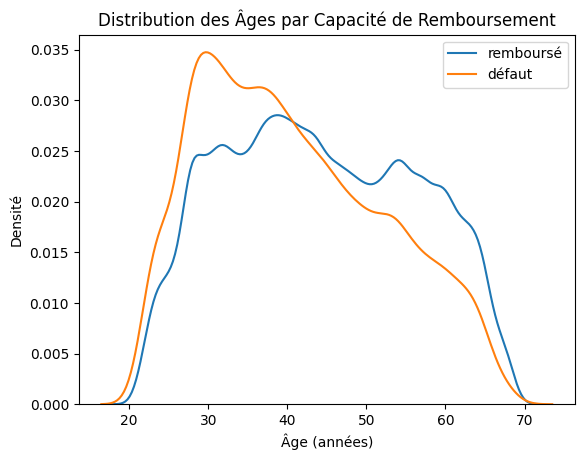

In [18]:
# Conversion de DAYS_BIRTH en √¢ge en ann√©es directement
sns.kdeplot(train_df.loc[train_df['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'rembours√©')
sns.kdeplot(train_df.loc[train_df['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'd√©faut')

# Ajouter les √©tiquettes et le titre
plt.xlabel('√Çge (ann√©es)')
plt.ylabel('Densit√©')
plt.title('Distribution des √Çges par Capacit√© de Remboursement')
plt.legend(loc='upper right')
plt.show()

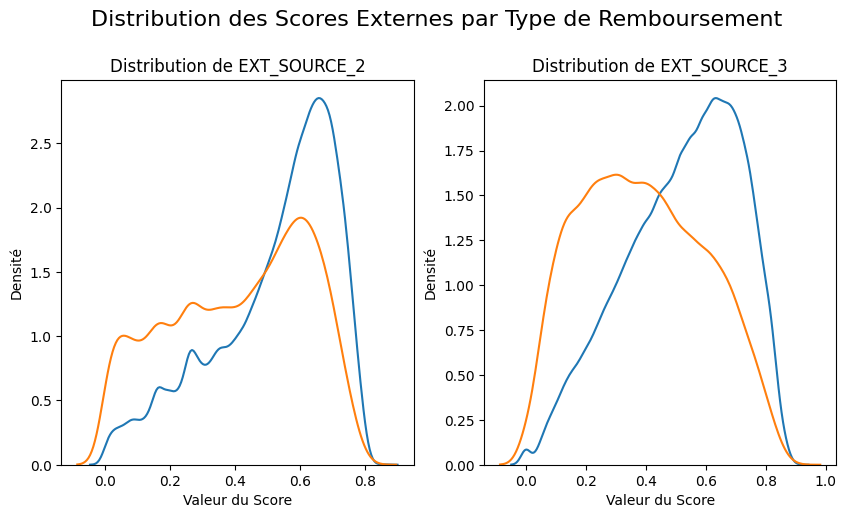

In [ ]:
# Liste des variables EXT_SOURCE √† visualiser
ext_sources = ['EXT_SOURCE_2', 'EXT_SOURCE_3']

# Cr√©er la figure et les sous-graphiques
plt.figure(figsize=(10, 5))
plt.suptitle('Distribution des Scores Externes par Type de Remboursement', y=1.02, fontsize=16)

# Boucle pour cr√©er un graphique pour chaque variable
for i, source in enumerate(ext_sources):
    # Cr√©er le sous-graphique √† la position i+1 dans une grille de 1 ligne et 2 colonnes
    plt.subplot(1, 2, i + 1)
    
    # Tracer la distribution pour les clients qui ont rembours√© (TARGET = 0)
    sns.kdeplot(train_df.loc[train_df['TARGET'] == 0, source], label = 'Rembours√©')
    
    # Tracer la distribution pour les clients qui ont fait d√©faut (TARGET = 1)
    sns.kdeplot(train_df.loc[train_df['TARGET'] == 1, source], label = 'D√©faut')
    
    # Ajouter un titre et des √©tiquettes
    plt.title(f'Distribution de {source}')
    plt.xlabel('Valeur du Score')
    plt.ylabel('Densit√©')

    # Afficher la l√©gende
    plt

Ces graphiques confirment que les variables EXT_SOURCE sont des indicateurs pertinents du risque de d√©faut, puisque des scores plus faibles sont syst√©matiquement associ√©s √† un risque plus √©lev√©.

## <a id='toc1_3_'></a>[Modelisation](#toc0_)

In [20]:
# train set / test set
X = train_df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = train_df['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [21]:
# D√©finition de la fonction de co√ªt
def custom_cost(y_true, y_pred, cost_fp=1, cost_fn=10):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    return total_cost

neg_cost_scorer = make_scorer(custom_cost, greater_is_better=False)

In [22]:
# D√©finition des Pipelines de pr√©traitement
# Cr√©ation d'un transformateur pour le feature engineering manuel
preprocess_transformer = FunctionTransformer(preprocess_data, validate=False)

# ---- D√âFINIR LES LISTES DE FEATURES APR√àS LE FEATURE ENGINEERING ----
df_temp = preprocess_data(X_train.copy())
numerical_features = df_temp.select_dtypes(include=np.number).columns.tolist()
categorical_features = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()
# ----------------------------------------------------------------------------------

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

### <a id='toc1_3_1_'></a>[Mod√®les Baseline](#toc0_)

In [23]:
# DummyClassifier
print("--------------------------------------------------")
print("√âvaluation du DummyClassifier")
with mlflow.start_run(run_name="DummyClassifier"):
    dummy_model = DummyClassifier(strategy="most_frequent")
    dummy_pipeline = Pipeline(steps=[
        ('feature_engineering', preprocess_transformer),
        ('preprocessor', preprocessor),
        ('classifier', dummy_model)
    ])
    
    dummy_pipeline.fit(X_train, y_train)
    
    # Pr√©dictions sur le jeu de validation
    y_pred_proba_val = dummy_pipeline.predict_proba(X_val)[:, 1]
    y_pred_val = dummy_pipeline.predict(X_val)
    
    # Pr√©dictions sur le jeu d'entra√Ænement
    y_pred_proba_train = dummy_pipeline.predict_proba(X_train)[:, 1]
    y_pred_train = dummy_pipeline.predict(X_train)
    
    # Calcul des m√©triques de validation
    auc_score_val = roc_auc_score(y_val, y_pred_proba_val)
    cost_score_val = custom_cost(y_val, y_pred_val)
    accuracy_score_val = accuracy_score(y_val, y_pred_val)

    # Calcul des m√©triques d'entra√Ænement
    auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    cost_score_train = custom_cost(y_train, y_pred_train)
    accuracy_score_train = accuracy_score(y_train, y_pred_train)

    print(f"DummyClassifier - Score AUC (Train): {auc_score_train:.4f}")
    print(f"DummyClassifier - Accuracy (Train): {accuracy_score_train:.4f}")
    print(f"DummyClassifier - Co√ªt m√©tier (Train): {cost_score_train:.4f}")
    print("---")
    print(f"DummyClassifier - Score AUC (Validation): {auc_score_val:.4f}")
    print(f"DummyClassifier - Accuracy (Validation): {accuracy_score_val:.4f}")
    print(f"DummyClassifier - Co√ªt m√©tier (Validation): {cost_score_val:.4f}")
    
    mlflow.log_param("model_name", "dummy_classifier")
    mlflow.log_metric("train_auc", auc_score_train)
    mlflow.log_metric("train_cost", cost_score_train)
    mlflow.log_metric("train_accuracy", accuracy_score_train)
    mlflow.log_metric("val_auc", auc_score_val)
    mlflow.log_metric("val_cost", cost_score_val)
    mlflow.log_metric("val_accuracy", accuracy_score_val)
    
    model_results["Dummy Classifier"] = {
        "pipeline": dummy_pipeline, 
        "auc_train": auc_score_train, 
        "cost_train": cost_score_train, 
        "accuracy_train": accuracy_score_train,
        "auc_val": auc_score_val,
        "cost_val": cost_score_val,
        "accuracy_val": accuracy_score_val
    }
    mlflow.sklearn.log_model(sk_model=dummy_pipeline, artifact_path="dummy_classifier", registered_model_name="dummy_classifier")

--------------------------------------------------
√âvaluation du DummyClassifier
DummyClassifier - Score AUC (Train): 0.5000
DummyClassifier - Accuracy (Train): 0.9193
DummyClassifier - Co√ªt m√©tier (Train): 198600.0000
---
DummyClassifier - Score AUC (Validation): 0.5000
DummyClassifier - Accuracy (Validation): 0.9193
DummyClassifier - Co√ªt m√©tier (Validation): 49650.0000


2025/09/14 19:31:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 19:31:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'dummy_classifier'.
2025/09/14 19:31:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: dummy_classifier, version 1
Created version '1' of model 'dummy_classifier'.


üèÉ View run DummyClassifier at: http://127.0.0.1:5000/#/experiments/474524093679376131/runs/0327d64d8e0d484f96e227a1454b1701
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/474524093679376131


In [24]:
# Regression logistique
print("--------------------------------------------------")
print("√âvaluation de la R√©gression Logistique")
with mlflow.start_run(run_name="LogisticRegression"):
    lr_model = LogisticRegression(solver='liblinear', class_weight='balanced')
    lr_pipeline = Pipeline(steps=[
        ('feature_engineering', preprocess_transformer),
        ('preprocessor', preprocessor),
        ('classifier', lr_model)
    ])
    
    lr_pipeline.fit(X_train, y_train)
    
    # Pr√©dictions sur le jeu de validation
    y_pred_proba_val = lr_pipeline.predict_proba(X_val)[:, 1]
    y_pred_val = lr_pipeline.predict(X_val)
    
    # Pr√©dictions sur le jeu d'entra√Ænement
    y_pred_proba_train = lr_pipeline.predict_proba(X_train)[:, 1]
    y_pred_train = lr_pipeline.predict(X_train)
    
    # Calcul des m√©triques de validation
    auc_score_val = roc_auc_score(y_val, y_pred_proba_val)
    cost_score_val = custom_cost(y_val, y_pred_val)
    accuracy_score_val = accuracy_score(y_val, y_pred_val)
    
    # Calcul des m√©triques d'entra√Ænement
    auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    cost_score_train = custom_cost(y_train, y_pred_train)
    accuracy_score_train = accuracy_score(y_train, y_pred_train)
    
    print(f"Logistic Regression - Score AUC (Train): {auc_score_train:.4f}")
    print(f"Logistic Regression - Accuracy (Train): {accuracy_score_train:.4f}")
    print(f"Logistic Regression - Co√ªt m√©tier (Train): {cost_score_train:.4f}")
    print("---")
    print(f"Logistic Regression - Score AUC (Validation): {auc_score_val:.4f}")
    print(f"Logistic Regression - Accuracy (Validation): {accuracy_score_val:.4f}")
    print(f"Logistic Regression - Co√ªt m√©tier (Validation): {cost_score_val:.4f}")
    
    mlflow.log_param("model_name", "logistic_regression")
    mlflow.log_metric("train_auc", auc_score_train)
    mlflow.log_metric("train_cost", cost_score_train)
    mlflow.log_metric("train_accuracy", accuracy_score_train)
    mlflow.log_metric("val_auc", auc_score_val)
    mlflow.log_metric("val_cost", cost_score_val)
    mlflow.log_metric("val_accuracy", accuracy_score_val)
    mlflow.log_param("prediction_threshold", 0.5)
    
    model_results["Logistic Regression"] = {
        "pipeline": lr_pipeline,
        "auc_train": auc_score_train,
        "cost_train": cost_score_train,
        "accuracy_train": accuracy_score_train,
        "auc_val": auc_score_val,
        "cost_val": cost_score_val,
        "accuracy_val": accuracy_score_val
    }
    mlflow.sklearn.log_model(sk_model=lr_pipeline, artifact_path="logistic_regression", registered_model_name="logistic_regression")

--------------------------------------------------
√âvaluation de la R√©gression Logistique
Logistic Regression - Score AUC (Train): 0.7501
Logistic Regression - Accuracy (Train): 0.6887
Logistic Regression - Co√ªt m√©tier (Train): 133487.0000
---
Logistic Regression - Score AUC (Validation): 0.7534
Logistic Regression - Accuracy (Validation): 0.6897
Logistic Regression - Co√ªt m√©tier (Validation): 33107.0000


2025/09/14 19:33:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 19:34:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'logistic_regression'.
2025/09/14 19:34:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: logistic_regression, version 1
Created version '1' of model 'logistic_regression'.


üèÉ View run LogisticRegression at: http://127.0.0.1:5000/#/experiments/474524093679376131/runs/c110c79a3f33491e8c45498da9fed7b4
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/474524093679376131


### <a id='toc1_3_2_'></a>[LightGBM](#toc0_)

#### <a id='toc1_3_2_1_'></a>[Mod√®le LightGBM par d√©faut](#toc0_)

In [25]:
# Mod√®le LightGBM par d√©faut
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
scale_pos_weight = neg_count / pos_count

lgbm_model_default = lgb.LGBMClassifier(objective='binary', verbose=-1, random_state=0, n_jobs=-1, scale_pos_weight=scale_pos_weight)
lgbm_pipeline_default = ImbPipeline(steps=[
    ('feature_engineering', preprocess_transformer),
    ('preprocessor', preprocessor),
    ('classifier', lgbm_model_default)
])

print("--------------------------------------------------")
print("Validation crois√©e du mod√®le LGBM par d√©faut")

cv_results = cross_validate(
    lgbm_pipeline_default,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    scoring={'roc_auc': 'roc_auc', 'neg_cost': neg_cost_scorer, 'accuracy': 'accuracy'},
    n_jobs=-1
)

auc_cv = np.mean(cv_results['test_roc_auc'])
cost_cv = -np.mean(cv_results['test_neg_cost'])
accuracy_cv = np.mean(cv_results['test_accuracy'])

print(f"LGBM - Score AUC moyen (CV): {auc_cv:.4f}")
print(f"LGBM - Accuracy moyenne (CV): {accuracy_cv:.4f}")
print(f"LGBM - Co√ªt m√©tier moyen (CV): {cost_cv:.4f}")

--------------------------------------------------
Validation crois√©e du mod√®le LGBM par d√©faut
LGBM - Score AUC moyen (CV): 0.7613
LGBM - Accuracy moyenne (CV): 0.7071
LGBM - Co√ªt m√©tier moyen (CV): 32482.0000


In [26]:
# Validation finale avec enregistrement MLflow
print("--------------------------------------------------")
print("√âvaluation et enregistrement du mod√®le LGBM par d√©faut")
with mlflow.start_run(run_name="LGBM_Default"):
    # Entra√Ænement sur le jeu d'entra√Ænement complet
    lgbm_pipeline_default.fit(X_train, y_train)

    # Pr√©dictions sur le jeu de validation
    y_pred_proba_val = lgbm_pipeline_default.predict_proba(X_val)[:, 1]
    y_pred_val = lgbm_pipeline_default.predict(X_val)

    # Pr√©dictions sur le jeu d'entra√Ænement
    y_pred_proba_train = lgbm_pipeline_default.predict_proba(X_train)[:, 1]
    y_pred_train = lgbm_pipeline_default.predict(X_train)

    # Calcul des m√©triques
    auc_score_val = roc_auc_score(y_val, y_pred_proba_val)
    cost_score_val = custom_cost(y_val, y_pred_val)
    accuracy_score_val = accuracy_score(y_val, y_pred_val)

    auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    cost_score_train = custom_cost(y_train, y_pred_train)
    accuracy_score_train = accuracy_score(y_train, y_pred_train)

    print(f"LGBM - Score AUC (Train): {auc_score_train:.4f}")
    print(f"LGBM - Accuracy (Train): {accuracy_score_train:.4f}")
    print(f"LGBM - Co√ªt m√©tier (Train): {cost_score_train:.4f}")
    print("---")
    print(f"LGBM - Score AUC (Validation): {auc_score_val:.4f}")
    print(f"LGBM - Accuracy (Validation): {accuracy_score_val:.4f}")
    print(f"LGBM - Co√ªt m√©tier (Validation): {cost_score_val:.4f}")

    # R√©cup√©ration et pr√©fixage des param√®tres d√©sir√©s pour l'enregistrement MLflow
    default_params = lgbm_pipeline_default.named_steps['classifier'].get_params()
    desired_params = {
        'classifier__learning_rate': default_params['learning_rate'],
        'classifier__num_leaves': default_params['num_leaves'],
        'classifier__n_estimators': default_params['n_estimators']
    }
    
    # Enregistrement dans MLflow
    mlflow.log_param("model_name", "lgbm_default")
    mlflow.log_params(desired_params)
    mlflow.log_metric("train_auc", auc_score_train)
    mlflow.log_metric("train_cost", cost_score_train)
    mlflow.log_metric("train_accuracy", accuracy_score_train)
    mlflow.log_metric("val_auc", auc_score_val)
    mlflow.log_metric("val_cost", cost_score_val)
    mlflow.log_metric("val_accuracy", accuracy_score_val)
    mlflow.log_param("prediction_threshold", 0.5)

    model_results["LGBM Default"] = {
        "pipeline": lgbm_pipeline_default,
        "auc_train": auc_score_train,
        "cost_train": cost_score_train,
        "accuracy_train": accuracy_score_train,
        "auc_val": auc_score_val,
        "cost_val": cost_score_val,
        "accuracy_val": accuracy_score_val
    }
    mlflow.sklearn.log_model(sk_model=lgbm_pipeline_default, artifact_path="lgbm_default", registered_model_name="lgbm_default")

--------------------------------------------------
√âvaluation et enregistrement du mod√®le LGBM par d√©faut


c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM - Score AUC (Train): 0.8030
LGBM - Accuracy (Train): 0.7116
LGBM - Co√ªt m√©tier (Train): 117365.0000
---
LGBM - Score AUC (Validation): 0.7680
LGBM - Accuracy (Validation): 0.7056
LGBM - Co√ªt m√©tier (Validation): 31500.0000


2025/09/14 19:35:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 19:35:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'lgbm_default'.
2025/09/14 19:35:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lgbm_default, version 1
Created version '1' of model 'lgbm_default'.


üèÉ View run LGBM_Default at: http://127.0.0.1:5000/#/experiments/474524093679376131/runs/4f280103a95543a58ce0a0886fc386e6
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/474524093679376131


#### <a id='toc1_3_2_2_'></a>[Optimisation des hyperparam√®tres](#toc0_)

In [27]:
# D√©finition des param√®tres pour la recherche par grille
param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__num_leaves': [20, 31, 40],
    'classifier__n_estimators': [100, 300, 700]
}

# Mod√®le LightGBM
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
scale_pos_weight = neg_count / pos_count

lgbm_model_tuned = lgb.LGBMClassifier(
    objective='binary', verbose=-1, random_state=0, n_jobs=-1, scale_pos_weight=scale_pos_weight
)

# Cr√©ation de la pipeline pour l'optimisation
lgbm_pipeline_tuned = ImbPipeline(steps=[
    ('feature_engineering', preprocess_transformer),
    ('preprocessor', preprocessor),
    ('classifier', lgbm_model_tuned)
])

print("--------------------------------------------------")
print("Optimisation des hyperparam√®tres avec GridSearchCV")

grid_search = GridSearchCV(
    estimator=lgbm_pipeline_tuned,
    param_grid=param_grid,
    scoring=neg_cost_scorer,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_cost_cv = -grid_search.best_score_

print("\nMeilleurs param√®tres trouv√©s :", best_params)
print(f"Meilleur co√ªt m√©tier moyen (CV) : {best_cost_cv:.4f}")

--------------------------------------------------
Optimisation des hyperparam√®tres avec GridSearchCV
Fitting 4 folds for each of 27 candidates, totalling 108 fits

Meilleurs param√®tres trouv√©s : {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 300, 'classifier__num_leaves': 31}
Meilleur co√ªt m√©tier moyen (CV) : 32308.5000


In [28]:
print("--------------------------------------------------")
print("√âvaluation et enregistrement du meilleur mod√®le LGBM")
with mlflow.start_run(run_name="LGBM_Optimized"):
    # Le meilleur estimateur est la pipeline compl√®te d√©j√† entra√Æn√©e par GridSearchCV
    final_lgbm_model = grid_search.best_estimator_

    # Pr√©dictions sur le jeu de validation
    y_pred_proba_val = final_lgbm_model.predict_proba(X_val)[:, 1]
    y_pred_val = final_lgbm_model.predict(X_val)

    # Pr√©dictions sur le jeu d'entra√Ænement
    y_pred_proba_train = final_lgbm_model.predict_proba(X_train)[:, 1]
    y_pred_train = final_lgbm_model.predict(X_train)
    
    # Calcul des m√©triques
    auc_score_val = roc_auc_score(y_val, y_pred_proba_val)
    cost_score_val = custom_cost(y_val, y_pred_val)
    accuracy_score_val = accuracy_score(y_val, y_pred_val)

    auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    cost_score_train = custom_cost(y_train, y_pred_train)
    accuracy_score_train = accuracy_score(y_train, y_pred_train)

    print(f"LGBM Optimis√© - Score AUC (Train): {auc_score_train:.4f}")
    print(f"LGBM Optimis√© - Accuracy (Train): {accuracy_score_train:.4f}")
    print(f"LGBM Optimis√© - Co√ªt m√©tier (Train): {cost_score_train:.4f}")
    print("---")
    print(f"LGBM Optimis√© - Score AUC (Validation): {auc_score_val:.4f}")
    print(f"LGBM Optimis√© - Accuracy (Validation): {accuracy_score_val:.4f}")
    print(f"LGBM Optimis√© - Co√ªt m√©tier (Validation): {cost_score_val:.4f}")
    
    # Enregistrement dans MLflow
    mlflow.log_params(best_params)
    mlflow.log_metric("train_auc", auc_score_train)
    mlflow.log_metric("train_cost", cost_score_train)
    mlflow.log_metric("train_accuracy", accuracy_score_train)
    mlflow.log_metric("val_auc", auc_score_val)
    mlflow.log_metric("val_cost", cost_score_val)
    mlflow.log_metric("val_accuracy", accuracy_score_val)
    mlflow.log_param("prediction_threshold", 0.5)
    
    model_results["LGBM Optimized"] = {
        "pipeline": final_lgbm_model,
        "auc_train": auc_score_train,
        "cost_train": cost_score_train,
        "accuracy_train": accuracy_score_train,
        "auc_val": auc_score_val,
        "cost_val": cost_score_val,
        "accuracy_val": accuracy_score_val
    }
    mlflow.sklearn.log_model(sk_model=final_lgbm_model, artifact_path="lgbm_optimized", registered_model_name="lgbm_optimized")

--------------------------------------------------
√âvaluation et enregistrement du meilleur mod√®le LGBM


c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM Optimis√© - Score AUC (Train): 0.8203
LGBM Optimis√© - Accuracy (Train): 0.7248
LGBM Optimis√© - Co√ªt m√©tier (Train): 111287.0000
---
LGBM Optimis√© - Score AUC (Validation): 0.7686
LGBM Optimis√© - Accuracy (Validation): 0.7150
LGBM Optimis√© - Co√ªt m√©tier (Validation): 31386.0000


2025/09/14 19:59:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 19:59:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'lgbm_optimized'.
2025/09/14 19:59:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lgbm_optimized, version 1
Created version '1' of model 'lgbm_optimized'.


üèÉ View run LGBM_Optimized at: http://127.0.0.1:5000/#/experiments/474524093679376131/runs/695f36c17b0a446b93f366ad785be7a8
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/474524093679376131


#### <a id='toc1_3_2_3_'></a>[Optimisation du seuil](#toc0_)

c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--------------------------------------------------
Meilleur seuil de pr√©diction sur le jeu de validation: 0.52
M√©triques pour le seuil optimal:
Val AUC: 0.7686
Val Accuracy: 0.7371
Val Cost: 31073


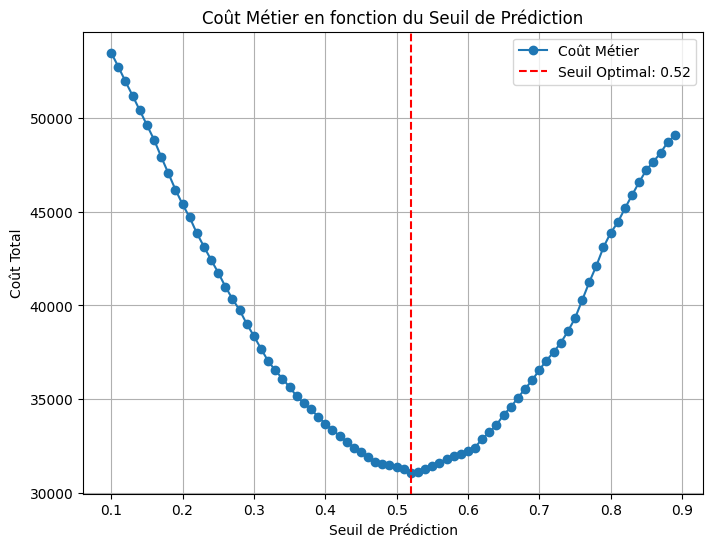

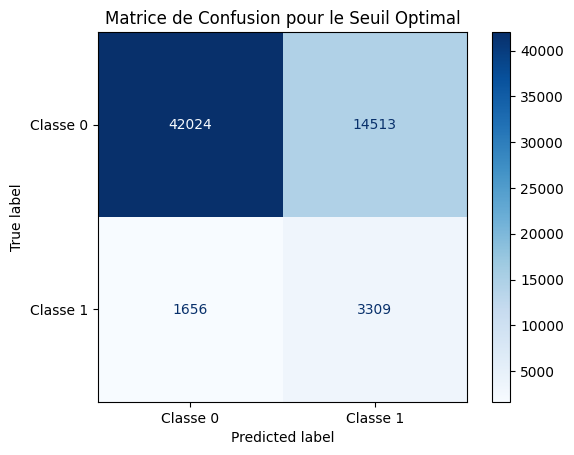

In [29]:
# R√©cup√©rer le meilleur mod√®le apr√®s l'optimisation des hyperparam√®tres
final_lgbm_model = grid_search.best_estimator_
y_val_proba = final_lgbm_model.predict_proba(X_val)[:, 1]

# Optimisation du seuil de pr√©diction sur le jeu de validation
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
min_cost = float('inf')
costs_list = []

for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    current_cost = custom_cost(y_val, y_val_pred)
    costs_list.append(current_cost)

    if current_cost < min_cost:
        min_cost = current_cost
        best_threshold = threshold

y_val_pred_optimal = (y_val_proba >= best_threshold).astype(int)

# Calcul des m√©triques pour le seuil optimal
auc_optimal_val = roc_auc_score(y_val, y_val_proba)
accuracy_optimal_val = accuracy_score(y_val, y_val_pred_optimal)
cost_optimal_val = custom_cost(y_val, y_val_pred_optimal)

print("--------------------------------------------------")
print(f"Meilleur seuil de pr√©diction sur le jeu de validation: {best_threshold:.2f}")
print("M√©triques pour le seuil optimal:")
print(f"Val AUC: {auc_optimal_val:.4f}")
print(f"Val Accuracy: {accuracy_optimal_val:.4f}")
print(f"Val Cost: {cost_optimal_val}")

# Affichage du co√ªt en fonction du seuil
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(thresholds, costs_list, marker='o', linestyle='-', label="Co√ªt M√©tier")
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Seuil Optimal: {best_threshold:.2f}")
plt.title("Co√ªt M√©tier en fonction du Seuil de Pr√©diction")
plt.xlabel("Seuil de Pr√©diction")
plt.ylabel("Co√ªt Total")
plt.legend()
plt.grid(True)
plt.show()

# Affichage de la matrice de confusion pour le seuil optimal
cm = confusion_matrix(y_val, y_val_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe 0', 'Classe 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion pour le Seuil Optimal")
plt.show()

In [30]:
# √âvaluation et enregistrement du meilleur mod√®le LGBM avec le seuil optimal
print("--------------------------------------------------")
print("Enregistrement du mod√®le LGBM optimis√© avec le seuil optimal")
with mlflow.start_run(run_name="LGBM_Final_Model"):
    # Le meilleur estimateur est la pipeline compl√®te d√©j√† entra√Æn√©e par GridSearchCV
    final_lgbm_model = grid_search.best_estimator_

    # Pr√©dictions sur le jeu de validation
    y_pred_proba_val = final_lgbm_model.predict_proba(X_val)[:, 1]
    
    # Calcul des pr√©dictions binaires avec le seuil optimal
    # Assurez-vous que la variable `best_threshold` est disponible √† partir du code pr√©c√©dent
    y_pred_val_optimal = (y_pred_proba_val >= best_threshold).astype(int)

    # Pr√©dictions sur le jeu d'entra√Ænement
    y_pred_proba_train = final_lgbm_model.predict_proba(X_train)[:, 1]
    y_pred_train_optimal = (y_pred_proba_train >= best_threshold).astype(int)
    
    # Calcul des m√©triques avec le seuil optimal
    auc_score_val = roc_auc_score(y_val, y_pred_proba_val)
    cost_score_val = custom_cost(y_val, y_pred_val_optimal)
    accuracy_score_val = accuracy_score(y_val, y_pred_val_optimal)

    auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    cost_score_train = custom_cost(y_train, y_pred_train_optimal)
    accuracy_score_train = accuracy_score(y_train, y_pred_train_optimal)

    print(f"LGBM Optimis√© - Score AUC (Train): {auc_score_train:.4f}")
    print(f"LGBM Optimis√© - Accuracy (Train): {accuracy_score_train:.4f}")
    print(f"LGBM Optimis√© - Co√ªt m√©tier (Train): {cost_score_train:.4f}")
    print("---")
    print(f"LGBM Optimis√© - Score AUC (Validation): {auc_score_val:.4f}")
    print(f"LGBM Optimis√© - Accuracy (Validation): {accuracy_score_val:.4f}")
    print(f"LGBM Optimis√© - Co√ªt m√©tier (Validation): {cost_score_val:.4f}")
    
    # Enregistrement dans MLflow
    # Les param√®tres de l'optimisation GridSearchCV sont enregistr√©s
    mlflow.log_params(best_params)
    
    mlflow.log_metric("train_auc", auc_score_train)
    mlflow.log_metric("train_cost", cost_score_train)
    mlflow.log_metric("train_accuracy", accuracy_score_train)
    mlflow.log_metric("val_auc", auc_score_val)
    # Les m√©triques de validation sont enregistr√©es avec le seuil optimal
    mlflow.log_metric("val_cost", cost_score_val)
    mlflow.log_metric("val_accuracy", accuracy_score_val)
    # Le seuil optimal est enregistr√© en tant que param√®tre
    mlflow.log_param("prediction_threshold", round(best_threshold,2))
    
    model_results["LGBM Optimized"] = {
        "pipeline": final_lgbm_model,
        "auc_train": auc_score_train,
        "cost_train": cost_score_train,
        "accuracy_train": accuracy_score_train,
        "auc_val": auc_score_val,
        "cost_val": cost_score_val,
        "accuracy_val": accuracy_score_val
    }
    # Enregistrement du mod√®le avec le nom qui refl√®te l'optimisation
    mlflow.sklearn.log_model(sk_model=final_lgbm_model, artifact_path="LGBM_Final_Model", registered_model_name="LGBM_Final_Model")

--------------------------------------------------
Enregistrement du mod√®le LGBM optimis√© avec le seuil optimal


c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM Optimis√© - Score AUC (Train): 0.8203
LGBM Optimis√© - Accuracy (Train): 0.7448
LGBM Optimis√© - Co√ªt m√©tier (Train): 111626.0000
---
LGBM Optimis√© - Score AUC (Validation): 0.7686
LGBM Optimis√© - Accuracy (Validation): 0.7371
LGBM Optimis√© - Co√ªt m√©tier (Validation): 31073.0000


2025/09/14 19:59:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 19:59:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LGBM_Final_Model'.
2025/09/14 19:59:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBM_Final_Model, version 1
Created version '1' of model 'LGBM_Final_Model'.


üèÉ View run LGBM_Final_Model at: http://127.0.0.1:5000/#/experiments/474524093679376131/runs/0ac67f691dc542c681d4e9bda3e1f24e
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/474524093679376131


#### <a id='toc1_3_2_4_'></a>[Importance globale et locale des features](#toc0_)

Le SHAP (SHapley Additive exPlanations) est un outil puissant qui nous permet d'expliquer les pr√©dictions de notre mod√®le de deux mani√®res. D'abord, il nous offre une vue globale en montrant l'importance de chaque variable sur l'ensemble du mod√®le. Ensuite, il fournit des explications locales pour une pr√©diction sp√©cifique, ce qui nous permet de comprendre pourquoi le mod√®le a fait un choix particulier pour un individu donn√©

##### <a id='toc1_3_2_4_1_'></a>[Importance globale](#toc0_)

c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


--- Cr√©ation du SHAP Summary Plot (dot plot) ---


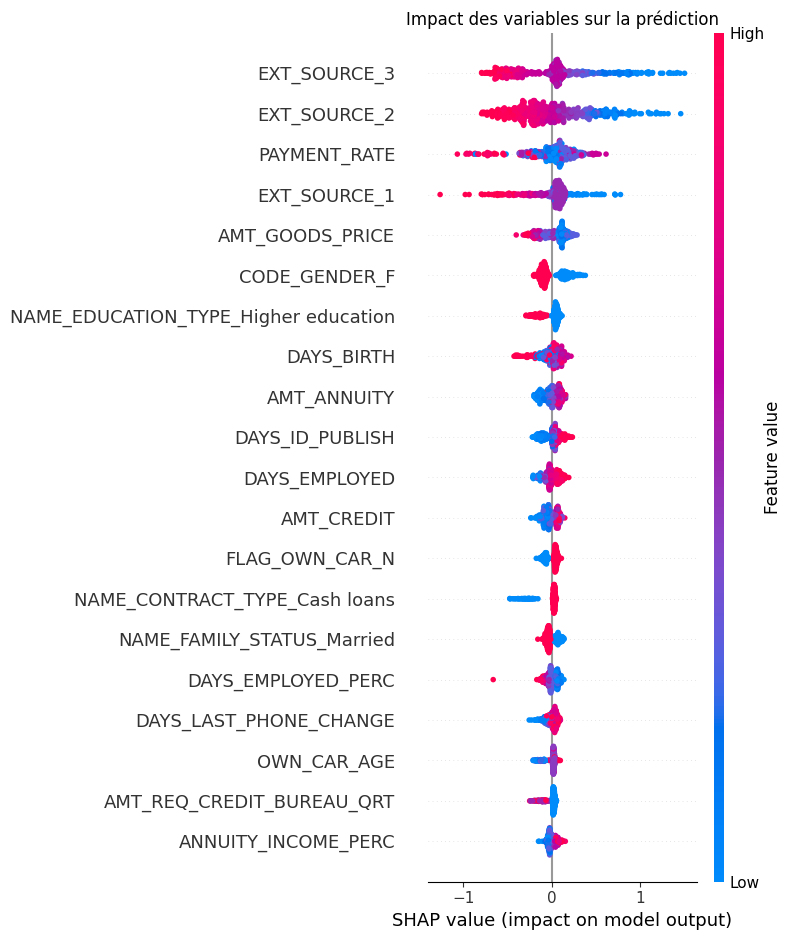

In [31]:
# ----------- √âtape 1 : Acc√®s au mod√®le et pr√©paration de SHAP -----------
lgbm_model = final_lgbm_model.named_steps['classifier']
preprocessor = final_lgbm_model.named_steps['preprocessor']

# Cr√©er un explainer SHAP pour le mod√®le
explainer = shap.TreeExplainer(lgbm_model)

# Calculer les valeurs SHAP pour le Summary Plot.
X_sample = X_train.sample(n=500, random_state=42)
X_sample_processed = preprocessor.transform(X_sample)

# Nettoyer les noms des colonnes pour un affichage plus clair
feature_names = preprocessor.get_feature_names_out()
feature_names_cleaned = [name.split('__')[-1] for name in feature_names]

# Convertir l'√©chantillon pr√©trait√© en DataFrame avec les noms de colonnes nettoy√©s
X_sample_processed = pd.DataFrame(X_sample_processed, columns=feature_names_cleaned, index=X_sample.index)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(X_sample_processed)

# ----------- √âtape 2 : Cr√©ation du SHAP Summary Plot (dot plot) -----------
print("--- Cr√©ation du SHAP Summary Plot (dot plot) ---")
plt.figure(figsize=(10, 15))
shap.summary_plot(
    shap_values,
    X_sample_processed,
    plot_type="dot",
    show=False
)
plt.title("Impact des variables sur la pr√©diction")
plt.xlabel("SHAP value (impact on model output)")
plt.tight_layout()
plt.show()


Ce graphique nous permet de comprendre non seulement quelles variables sont importantes, mais aussi comment elles influencent la pr√©diction du mod√®le en fonction de leurs valeurs.  
Les features les plus importantes sont dans l'ordre, ext_source_3, ext_source_2, payment_rate, etc. La position horizontale d'un point indique l'impact de cette variable sur la pr√©diction de la classe 1 (le d√©faut de paiement)
Pour les 3 variables ext_source_3, ext_source_2, payment_rate, la majorit√© des points rouges se trouvent √† gauche, ce qui signifie qu'une valeur √©lev√©e de cette variable diminue la probabilit√© de d√©faut de paiement

##### <a id='toc1_3_2_4_2_'></a>[Importance locale](#toc0_)

CLIENT AVEC ID 443433


L'ID client pour l'index 9 est : 443433

--- Analyse SHAP pour le client ID 443433 du jeu de validation (importance locale) ---


c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


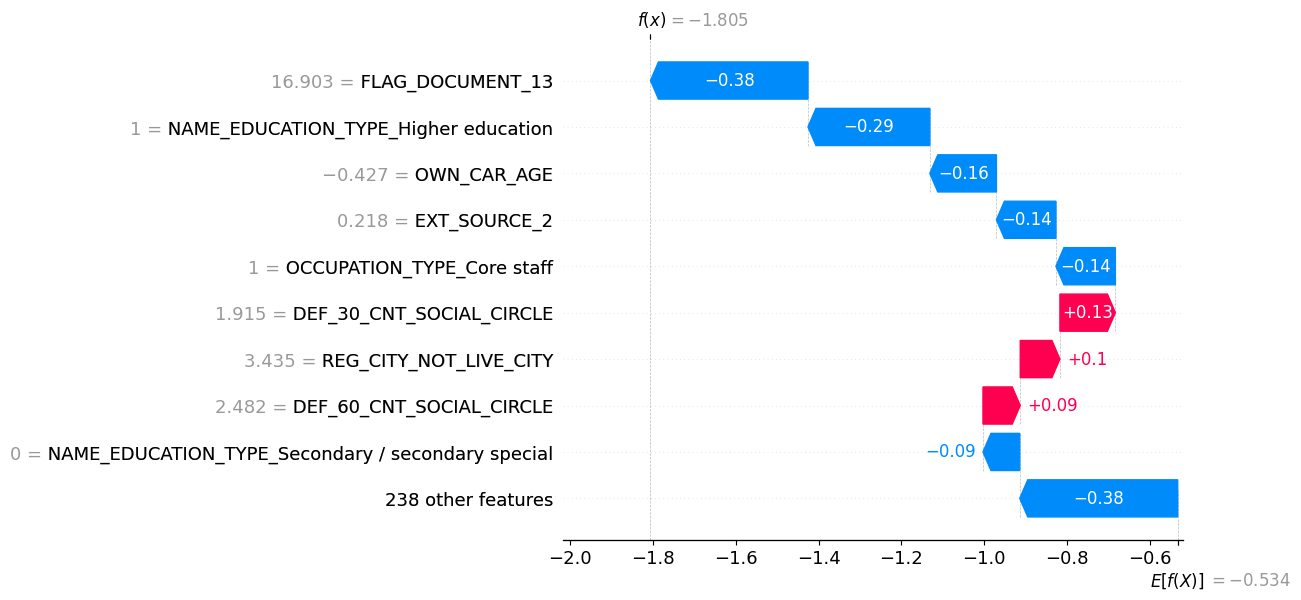

In [32]:
# --- Analyse SHAP pour un client sp√©cifique du jeu de validation ---
X_val_with_id = train_df.loc[X_val.index].copy()

# Client 1
client_id_9 = X_val_with_id.iloc[9]['SK_ID_CURR']
print("\nL'ID client pour l'index 9 est :", client_id_9)
print("\n--- Analyse SHAP pour le client ID 443433 du jeu de validation (importance locale) ---")

X_sample_val = X_val.sample(n=500, random_state=42)
X_sample_val_processed = preprocessor.transform(X_sample_val)
X_sample_val_processed = pd.DataFrame(X_sample_val_processed, columns=feature_names_cleaned, index=X_sample_val.index)
shap_values_val = explainer.shap_values(X_sample_val_processed)

instance_to_explain_index_9 = 9
instance_to_explain_9 = X_sample_val_processed.iloc[instance_to_explain_index_9]

if isinstance(shap_values_val, list) and len(shap_values_val) > 1:
    shap_values_local_9 = shap_values_val[1][instance_to_explain_index_9]
    expected_value_local_9 = explainer.expected_value[1]
else:
    shap_values_local_9 = shap_values_val[instance_to_explain_index_9]
    expected_value_local_9 = explainer.expected_value

display(shap.force_plot(
    expected_value_local_9,
    shap_values_local_9,
    instance_to_explain_9
))

explanation_object_9 = shap.Explanation(
    values=shap_values_local_9,
    base_values=expected_value_local_9,
    data=instance_to_explain_9,
    feature_names=X_sample_val_processed.columns.tolist()
)

shap.waterfall_plot(explanation_object_9)
plt.show()

CLIENT AVEC ID 427037


L'ID client pour l'index 46 est : 427037

--- Analyse SHAP pour le client ID 427037 du jeu de validation (importance locale) ---


c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


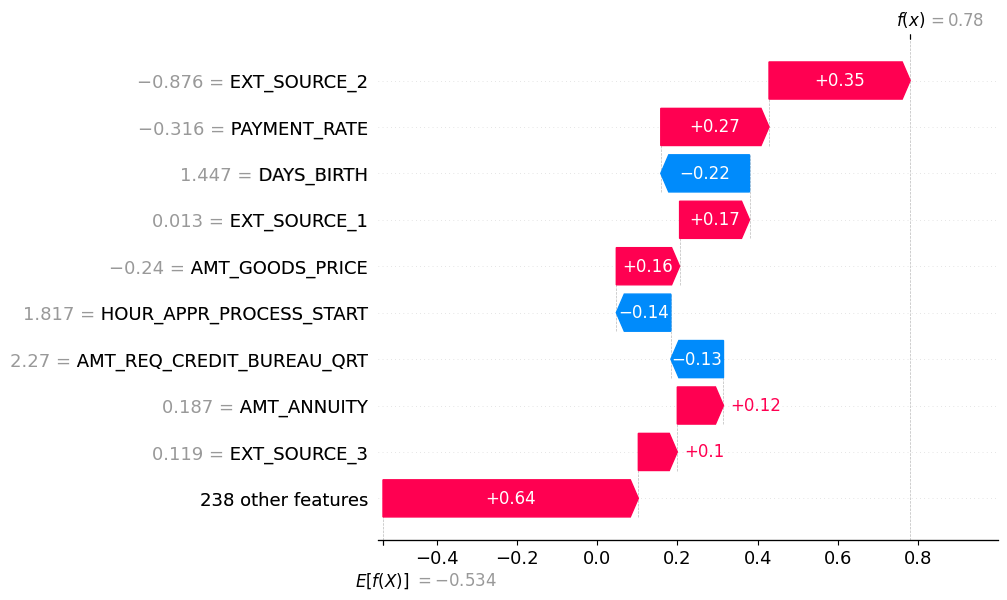

In [33]:
# Client 2
client_id_46 = X_val_with_id.iloc[46]['SK_ID_CURR']
print("\nL'ID client pour l'index 46 est :", client_id_46)
print("\n--- Analyse SHAP pour le client ID 427037 du jeu de validation (importance locale) ---")

X_sample_val_2 = X_val.sample(n=500, random_state=42)
X_sample_val_2_processed = preprocessor.transform(X_sample_val_2)
X_sample_val_2_processed = pd.DataFrame(X_sample_val_2_processed, columns=feature_names_cleaned, index=X_sample_val_2.index)
shap_values_val_2 = explainer.shap_values(X_sample_val_2_processed)

instance_to_explain_index_46 = 46
instance_to_explain_46 = X_sample_val_2_processed.iloc[instance_to_explain_index_46]

if isinstance(shap_values_val_2, list) and len(shap_values_val_2) > 1:
    shap_values_local_46 = shap_values_val_2[1][instance_to_explain_index_46]
    expected_value_local_46 = explainer.expected_value[1]
else:
    shap_values_local_46 = shap_values_val_2[instance_to_explain_index_46]
    expected_value_local_46 = explainer.expected_value

display(shap.force_plot(
    expected_value_local_46,
    shap_values_local_46,
    instance_to_explain_46
))

explanation_object_46 = shap.Explanation(
    values=shap_values_local_46,
    base_values=expected_value_local_46,
    data=instance_to_explain_46,
    feature_names=X_sample_val_2_processed.columns.tolist()
)

shap.waterfall_plot(explanation_object_46)
plt.show()

Ces graphiques sont des waterfalls plots de SHAP (SHapley Additive exPlanations), utilis√©s pour expliquer les pr√©dictions individuelles d'un mod√®le de machine learning. Ils d√©composent la contribution de chaque variable √† la pr√©diction finale du mod√®le. Les Barres rouges repr√©sentent les caract√©ristiques qui augmentent la pr√©diction par rapport √† la valeur de base. Les Barres bleues repr√©sentent les caract√©ristiques qui diminuent la pr√©diction.  

CLIENT AVEC ID 443433  
- FLAG_DOCUMENT_13 (16.903) a un impact tr√®s n√©gatif (-0.38). Le fait que ce drapeau de document soit 1 indique une forte probabilit√© de d√©faut de paiement.
- NAME_EDUCATION_TYPE (Higher education) a un impact n√©gatif significatif (-0.29), ce qui est contre-intuitif et pourrait r√©v√©ler un biais dans les donn√©es 
- OWN_CAR_AGE (-0.427) a un impact n√©gatif (-0.16). Une faible anciennet√© de voiture (valeur n√©gative) est associ√©e √† un risque de d√©faut.
- Autres caract√©ristiques : Les autres caract√©ristiques ont √©galement un impact majoritairement n√©gatif, confirmant la tendance de la pr√©diction finale.

CLIENT AVEC ID 427037
- EXT_SOURCE_2 (-0.876) a une forte contribution positive (+0.35). Une valeur faible pour cette caract√©ristique externe sugg√®re que le client est fiable.
- PAYMENT_RATE (-0.316) a une forte contribution positive (+0.27), ce qui pourrait indiquer une faible charge de paiement et donc un client plus s√ªr.
- Autres caract√©ristiques : De nombreuses autres caract√©ristiques (238) ont collectivement un impact positif fort (+0.64) sur la pr√©diction finale.


### <a id='toc1_3_3_'></a>[Sauvegarde du mod√®le](#toc0_)

In [34]:
# Sauvegarde du mod√®le final (pipeline)
joblib.dump(final_lgbm_model, 'modele_de_scoring.pkl')

print("Le mod√®le final (pipeline) a √©t√© sauvegard√© sous 'modele_de_scoring.pkl'")

Le mod√®le final (pipeline) a √©t√© sauvegard√© sous 'modele_de_scoring.pkl'


### <a id='toc1_3_4_'></a>[Test et Sauvegarde pour tester l'API](#toc0_)

In [39]:
# 1. S√©lectionner 20 clients √† partir de l'original (pour la coh√©rence avec l'API)
# Le DataFrame original n'a pas les noms de colonnes nettoy√©s.
df_original = pd.read_csv('application_train.csv')

# S√©lectionner 20 IDs al√©atoires pour l'√©chantillon
sample_ids = df_original.sample(n=20, random_state=42)['SK_ID_CURR']

# R√©cup√©rer les lignes compl√®tes pour ces IDs
raw_sample_clients = df_original[df_original['SK_ID_CURR'].isin(sample_ids)].copy()

# 2. Effectuer les pr√©dictions dans le notebook
# Nettoyer les noms des colonnes pour les rendre compatibles avec la pipeline
cleaned_sample_clients = raw_sample_clients.copy()
cleaned_sample_clients.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in cleaned_sample_clients.columns]

# Utiliser la pipeline pour pr√©dire sur ces donn√©es nettoy√©es
sample_proba_notebook = final_lgbm_model.predict_proba(cleaned_sample_clients)[:, 1]

# Classification avec le seuil optimal
sample_pred_notebook = (sample_proba_notebook >= best_threshold).astype(int)

print("\nR√©sultats de la pr√©diction dans le notebook:")
for i, row in results_notebook_df.iterrows():
    decision = "Refus√© (risque de d√©faut √©lev√©)" if row['Prediction_Optimal_Notebook'] == 1 else "Accept√© (faible risque)"
    print(f"Client {int(row['SK_ID_CURR'])} ‚Üí "
          f"Probabilit√©: {row['Probability_Notebook']:.4f}, "
          f"D√©cision: {decision}")
    

# 3. Pr√©parer le fichier JSON pour l'API (avec noms de colonnes originaux)
# On retire les colonnes que l'API ne devrait pas recevoir
raw_sample_clients.drop(['TARGET'], axis=1, inplace=True)
raw_sample_clients.to_json('sample_clients_raw_data.json', orient='records', indent=4)
print("\nDonn√©es brutes de l'√©chantillon pour l'API sauvegard√©es dans 'sample_clients_raw_data.json'")


R√©sultats de la pr√©diction dans le notebook:
Client 119647 ‚Üí Probabilit√©: 0.7196, D√©cision: Refus√© (risque de d√©faut √©lev√©)
Client 120952 ‚Üí Probabilit√©: 0.7050, D√©cision: Refus√© (risque de d√©faut √©lev√©)
Client 134561 ‚Üí Probabilit√©: 0.6391, D√©cision: Refus√© (risque de d√©faut √©lev√©)
Client 142232 ‚Üí Probabilit√©: 0.7283, D√©cision: Refus√© (risque de d√©faut √©lev√©)
Client 180689 ‚Üí Probabilit√©: 0.1806, D√©cision: Accept√© (faible risque)
Client 188909 ‚Üí Probabilit√©: 0.5790, D√©cision: Refus√© (risque de d√©faut √©lev√©)
Client 214010 ‚Üí Probabilit√©: 0.1668, D√©cision: Accept√© (faible risque)
Client 231383 ‚Üí Probabilit√©: 0.0516, D√©cision: Accept√© (faible risque)
Client 232220 ‚Üí Probabilit√©: 0.3177, D√©cision: Accept√© (faible risque)
Client 233043 ‚Üí Probabilit√©: 0.4842, D√©cision: Accept√© (faible risque)
Client 250804 ‚Üí Probabilit√©: 0.5598, D√©cision: Refus√© (risque de d√©faut √©lev√©)
Client 257374 ‚Üí Probabilit√©: 0.4583, D√©cision:

c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Le fichier requirements
# %pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


## <a id='toc1_4_'></a>[Data Drift](#toc0_)

On d√©tecte le data drift en comparant la distribution des donn√©es historiques (celles utilis√©es pour l'entra√Ænement) avec celle des nouvelles donn√©es de production.

Il existe deux types principaux de d√©rive :

Drift de la cible (Concept Drift) : La relation entre les donn√©es d'entr√©e et la variable cible (ce que vous essayez de pr√©dire) change. Par exemple, si l'impact du revenu sur le d√©faut de paiement d'un pr√™t √©volue.

Drift des caract√©ristiques (Feature Drift) : La distribution des caract√©ristiques d'entr√©e change. Par exemple, si l'√¢ge moyen des clients qui postulent pour un pr√™t augmente significativement par rapport aux donn√©es d'entra√Ænement.

Des outils comme Evidently ou NannyML permettent d'automatiser cette d√©tection en comparant les distributions statistiques des datasets.

Dans le but d'√©valuer la stabilit√© de notre mod√®le, nous allons analyser la d√©rive des caract√©ristiques (feature drift) entre nos donn√©es d'entra√Ænement et les donn√©es test. Cette analyse est cruciale car la performance d'un mod√®le de machine learning peut se d√©grader si la distribution des donn√©es sur lesquelles il a √©t√© entra√Æn√© diff√®re de celle des donn√©es qu'il rencontre en production.

Pour ce faire, nous utiliserons la biblioth√®que Evidently et son DataDriftPreset pour g√©n√©rer un rapport d√©taill√©. Ce rapport comparera la distribution de chaque variable de notre jeu de donn√©es de r√©f√©rence (df_train) √† celle de notre jeu de donn√©es actuel (df_test), identifiant ainsi les caract√©ristiques dont la distribution a significativement chang√©.

In [14]:
import pandas as pd
from utils import preprocess_data
from evidently import Report
from evidently.presets import DataDriftPreset  

# 1. Charger les datasets
df_train_raw = pd.read_csv("application_train.csv")
df_test_raw = pd.read_csv("application_test.csv")

# 2. Pr√©traitement
df_train = preprocess_data(df_train_raw)
df_test = preprocess_data(df_test_raw)

# 3. Construire le rapport avec le Preset de d√©rive des donn√©es
report = Report(
    metrics=[ DataDriftPreset() ]
)

# 4. Ex√©cuter le rapport
result = report.run(reference_data=df_train, current_data=df_test)

# 5. Sauvegarder en html
result.save_html("data_drift_report.html")
print("‚úÖ Rapport g√©n√©r√© : data_drift_report.html")



‚úÖ Rapport g√©n√©r√© : data_drift_report.html


Le rapport indique que 8.73% des variables pr√©sentent une d√©rive significative. Ce pourcentage est inf√©rieur au seuil de 10% g√©n√©ralement consid√©r√© comme un signal d'alarme critique pour la d√©gradation du mod√®le. Bien que le data drift soit bien pr√©sent, il n'est pas aussi g√©n√©ralis√©